# Image Processing<br>Plant Seedling Classification

##### Thomas Webb<br>March 13th, 2021

# Import Libraries

In [301]:
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import and Organize Data

In [302]:
train_path = "train.zip"
!mkdir temp_train

mkdir: temp_train: File exists


In [303]:
# Extract the files from train dataset to temp_train and temp_test folders 
# Will later be creating our own training, testing, and validation set out of the .zip file.
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

In [304]:
# The path to all images in training set. (* means include all folders and files.)
path = "./temp_train/*/*.png" 
files = glob(path)

trainImg = []
trainLabel = []                                            
j = 1
num = len(files)

# get images and labels, resize to 128x128
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  
    trainLabel.append(img.split('/')[-2])  
    j += 1

trainImg = np.asarray(trainImg)  
trainLabel = np.asarray(trainLabel)  

print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750,)


In [305]:
list = np.unique(trainLabel)
list

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

Cleavers


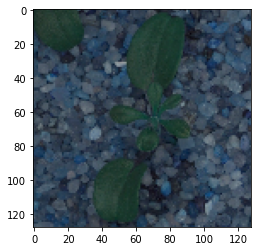

Sugar beet


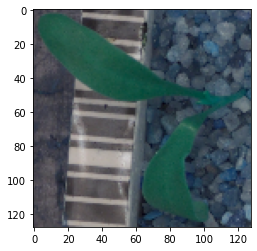

Common Chickweed


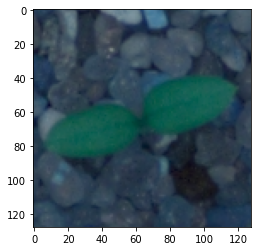

Loose Silky-bent


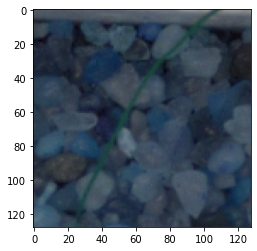

Scentless Mayweed


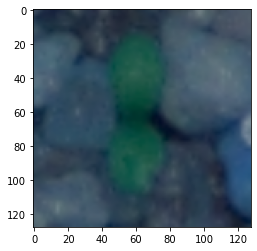

Shepherds Purse


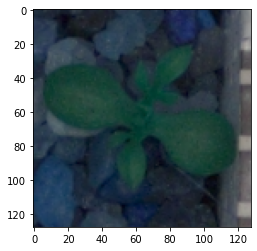

Fat Hen


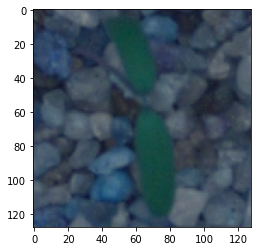

Common wheat


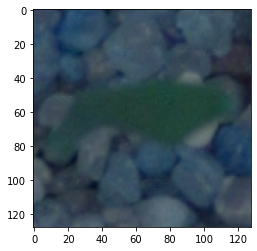

Black-grass


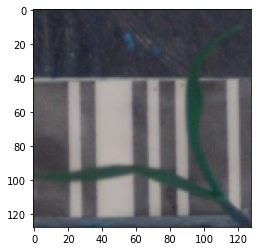

Small-flowered Cranesbill


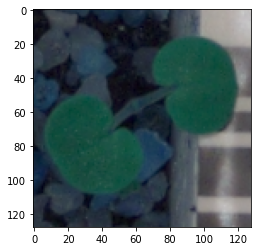

Charlock


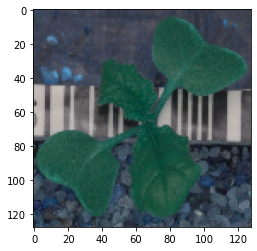

Maize


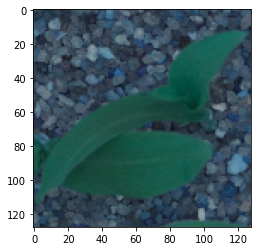

In [306]:
examples = [0, 300, 700, 1300, 2000, 2500, 2800, 3300, 3500, 3700, 4300, 4700]
for i in examples:
    plt.imshow(trainImg[i])
    print(trainLabel[i])
    plt.show()

##### `Insights:`
There are 12 unique seedling species and an example of each one can be seen here in a 128x128x3 labeled picture. 

# Data Pre-processing

In [307]:
x = trainImg
y = trainLabel

In [308]:
# normalization
x = x.astype('float32')
x /= 255

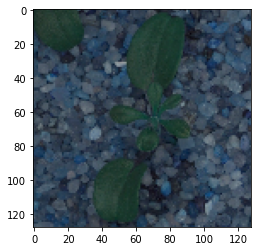

In [309]:
plt.imshow(trainImg[0])

In [310]:
# gaussian blurring
trainImg[0] = cv2.GaussianBlur(trainImg[0],(3,3),0)

In [311]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750,)


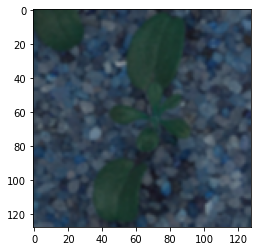

In [312]:
# visualize after pre-processing
plt.imshow(trainImg[0])

# Data Compatibility

In [313]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [314]:
# Further split testing data into equal sized testing and validation data sets.
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=1)

In [315]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

# verify that the data has been normalized
print("Maximum x_train value:",x_train.max())
print("Minimum x_train value:",x_train.min())

(3325, 128, 128, 3)
(3325,)
(712, 128, 128, 3)
(712,)
(713, 128, 128, 3)
(713,)
Maximum x_train value: 1.0
Minimum x_train value: 0.0


# Convert labels from digits to one-hot vectors

In [316]:
# Reshape data into shapes compatibile with Keras model
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values
y_val = pd.get_dummies(y_val).values

In [317]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [318]:
directory = {0:"Black Grass",
                 1:"Charlock",
                 2:"Cleavers",
                 3:"Common Chickweed",
                 4:"Common Wheat",
                 5:"Fat Hen",
                 6:"Loose Silky-bent",
                 7:"Maize",
                 8:"Scentless Mayweed",
                 9:"Shepherds Purse",
                 10:"Small-Flowered Cranesbill",
                 11:"Sugar beet"}

# Print the label for y_train[0]

In [319]:
# Print the label for y_train[0]
print(y_train[0])
def get_label(img):
    if y_train[img][0] == 1:
        print("Black Grass")
    elif y_train[img][1] == 1:
        print("Charlock")
    elif y_train[img][2] == 1:
        print("Cleavers")
    elif y_train[img][3] == 1:
        print("Common Chickweed")
    elif y_train[img][4] == 1:
        print("Common Wheat")
    elif y_train[img][5] == 1:
        print("Fat Hen")
    elif y_train[img][6] == 1:
        print("Loose Silky-bent")
    elif y_train[img][7] == 1:
        print("Maize")
    elif y_train[img][8] == 1:
        print("Scentless Mayweed")
    elif y_train[img][9] == 1:
        print("Shepherds Purse")
    elif y_train[img][10] == 1:
        print("Small-Flowered Cranesbill")
    elif y_train[img][11] == 1:
        print("Sugar beet")

get_label(0)

[0 0 0 0 0 0 0 0 0 0 1 0]
Small-Flowered Cranesbill


# Building the CNN

In [320]:
# Define layers
batch_size = None

model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
# model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(12, activation="softmax"))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 64)       

# Set Optimizer

In [321]:
# Set 'Adam' optimizer and 'categorical_crossentropy' loss function
optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            epsilon=1e-08)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', 
              metrics = 'accuracy')

In [322]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq=1)

# Fit model

In [323]:
# # fit the model
# history = model.fit(x_train, 
#                     y_train,  
#                     epochs=32, 
#                     batch_size=16, 
#                     verbose=1)

history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    verbose=1)
#                     callbacks=[early_stopping,model_checkpoint])

# plot training history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

Epoch 1/40
104/104 [==============================] - 133s 1s/step - loss: 3.9770 - accuracy: 0.1406 - val_loss: 7.9198 - val_accuracy: 0.1685
Epoch 2/40
104/104 [==============================] - 136s 1s/step - loss: 2.0379 - accuracy: 0.3035 - val_loss: 11.4870 - val_accuracy: 0.1433
Epoch 3/40
104/104 [==============================] - 153s 1s/step - loss: 1.6447 - accuracy: 0.4099 - val_loss: 8.6625 - val_accuracy: 0.1433
Epoch 4/40
104/104 [==============================] - 146s 1s/step - loss: 1.4498 - accuracy: 0.4928 - val_loss: 6.5974 - val_accuracy: 0.1924
Epoch 5/40
104/104 [==============================] - 154s 1s/step - loss: 1.2485 - accuracy: 0.5746 - val_loss: 6.5606 - val_accuracy: 0.2331
Epoch 6/40
104/104 [==============================] - 146s 1s/step - loss: 1.1609 - accuracy: 0.6002 - val_loss: 4.5197 - val_accuracy: 0.4565
Epoch 7/40
104/104 [==============================] - 142s 1s/step - loss: 1.0610 - accuracy: 0.6281 - val_loss: 2.7167 - val_accuracy: 0.561

# Evaluate Model

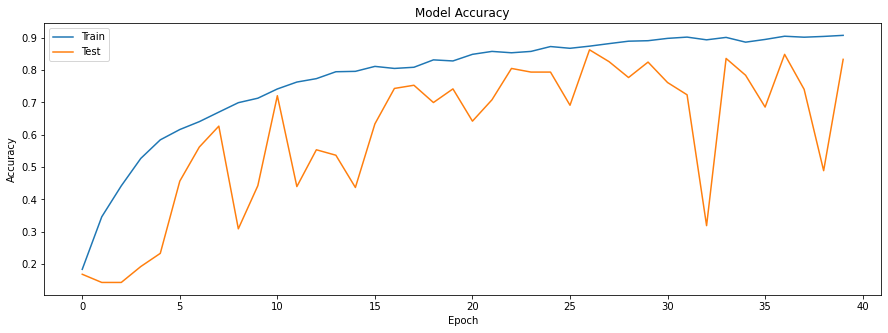

In [324]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

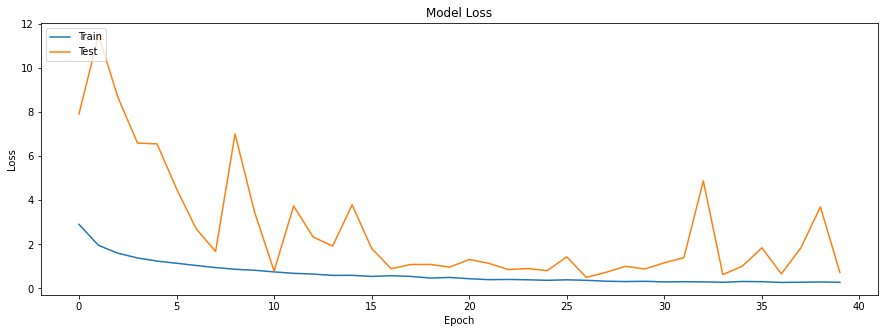

In [325]:
# plot training history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [326]:
# create prediction based of the model fit
Y_pred_cls = np.argmax(model.predict(x_test), axis = -1)

In [327]:
# convert y_test values back to integers that match the model output instead of one-hot vectors
truths = []
for i in range(len(y_test)):
    if y_test[i][0] == 1:
        truths.append(0)
    elif y_test[i][1] == 1:
        truths.append(1)
    elif y_test[i][2] == 1:
        truths.append(2)
    elif y_test[i][3] == 1:
        truths.append(3)
    elif y_test[i][4] == 1:
        truths.append(4)
    elif y_test[i][5] == 1:
        truths.append(5)
    elif y_test[i][6] == 1:
        truths.append(6)
    elif y_test[i][7] == 1:
        truths.append(7)
    elif y_test[i][8] == 1:
        truths.append(8)
    elif y_test[i][9] == 1:
        truths.append(9)
    elif y_test[i][10] == 1:
        truths.append(10)
    elif y_test[i][11] == 1:
        truths.append(11)
    else:
        truths.append('False')
truths = np.array(truths)

# Confusion Matrix

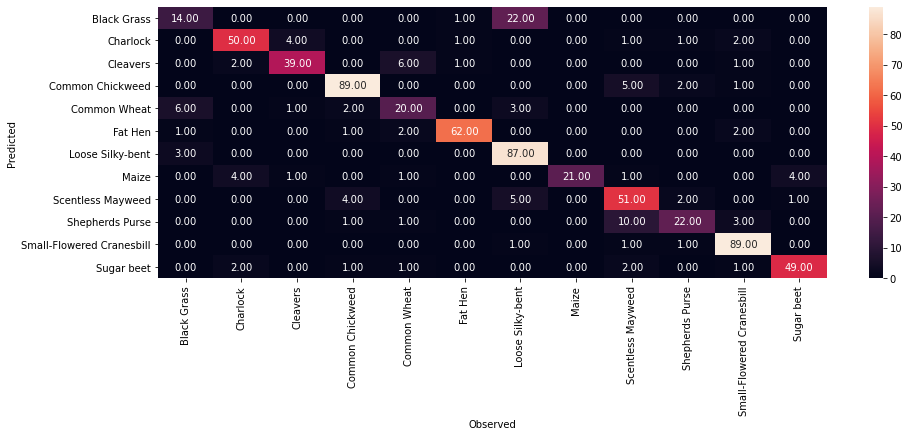

In [328]:
from sklearn.metrics import confusion_matrix
def draw_cm(actual,predicted):
    cm = confusion_matrix(truths,Y_pred_cls)
    plt.figure(figsize=(15,5))
    sns.heatmap(cm, annot = True, 
                fmt = '.2f', 
                xticklabels = ["Black Grass","Charlock","Cleavers","Common Chickweed","Common Wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-Flowered Cranesbill","Sugar beet"], 
                yticklabels = ["Black Grass","Charlock","Cleavers","Common Chickweed","Common Wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-Flowered Cranesbill","Sugar beet"])
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
draw_cm(truths,Y_pred_cls)

# Visualize Predictions

6
6
The CNN prediction was correct


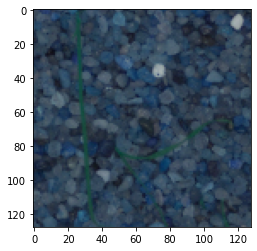

10
10
The CNN prediction was correct


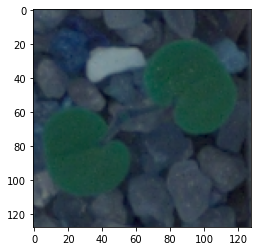

11
7
The CNN prediction was incorrect


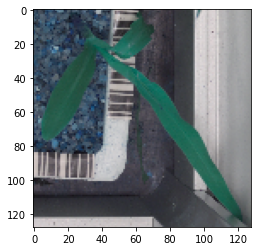

6
6
The CNN prediction was correct


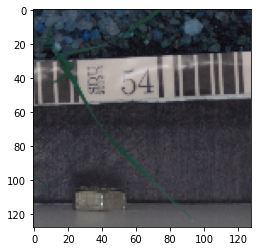

4
2
The CNN prediction was incorrect


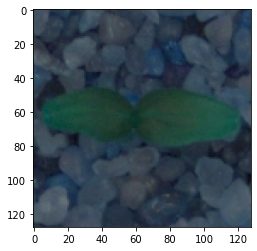

In [329]:
# x_test[2]
cases = [2, 3, 33, 36, 59]
for i in cases:
    print(Y_pred_cls[i])
    print(truths[i])
    plt.imshow(x_test[i])
    if y_test[i][Y_pred_cls[i]] == 1:
        print("The CNN prediction was correct")
    else:
        print("The CNN prediction was incorrect")
    plt.show()